In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
iowa = '/Users/Kate/Desktop/ECON628-01-katewu727/datasets/iowa_liquor/Iowa_Liquor_sales_sample_10pct.csv'
iowa = pd.read_csv(iowa)

## 1. Taking a look at the dataset

In [3]:
# Observe the first 3 data in the dataframe
iowa.head(3)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34


In [4]:
iowa.dtypes

Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [5]:
# Change variable names
new_colnames = [x.lower().replace(')','').replace('(','').replace(' ','_') for x in iowa.columns]
iowa.columns = new_colnames

## 2. Cleaning the dataset

### 2-1 Removing signs and converting formats

In [7]:
# Remove dollar signs
iowa['state_bottle_cost']=iowa['state_bottle_cost'].str.replace('$','')
iowa['state_bottle_retail']=iowa['state_bottle_retail'].str.replace('$','')
iowa['sale_dollars']=iowa['sale_dollars'].str.replace('$','')

In [8]:
# Convert float to int 
iowa['county_number']=iowa['county_number'].fillna(0.0).astype(int)
iowa['category']= iowa['category'].fillna(0.0).astype(int)

In [9]:
# Convert str to int
iowa['state_bottle_cost']= pd.to_numeric(iowa['state_bottle_cost'],
                                        errors="coerce")

iowa['state_bottle_retail']= pd.to_numeric(iowa['state_bottle_retail'],
                                        errors="coerce")

iowa['sale_dollars']= pd.to_numeric(iowa['sale_dollars'],
                                        errors="coerce")

### 2-2 Dealing with missing observations

In [10]:
# Detect NAN in the dataframe
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                  0
county_number             0
county                 1077
category                  0
category_name           632
vendor_number             0
item_number               0
item_description          0
bottle_volume_ml          0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sale_dollars              0
volume_sold_liters        0
volume_sold_gallons       0
dtype: int64

In [11]:
iowa=iowa.dropna()

### 2-3 Duplicated city names

In [12]:
print sorted(iowa.city.unique())

['ACKLEY', 'ADAIR', 'ADEL', 'AFTON', 'AKRON', 'ALBIA', 'ALDEN', 'ALGONA', 'ALLISON', 'ALTA', 'ALTOONA', 'AMES', 'ANAMOSA', 'ANITA', 'ANKENY', 'ANTHON', 'ARLINGTON', 'ARMSTRONG', "ARNOLD'S PARK", 'ARNOLDS PARK', 'ATLANTIC', 'AUDUBON', 'AURELIA', 'AVOCA', 'BALDWIN', 'BANCROFT', 'BAXTER', 'BEDFORD', 'BELLE PLAINE', 'BELLEVUE', 'BELMOND', 'BETTENDORF', 'BEVINGTON', 'BLOOMFIELD', 'BLUE GRASS', 'BONDURANT', 'BOONE', 'BRITT', 'BROOKLYN', 'BUFFALO', 'BUFFALO CENTER', 'BURLINGTON', 'BUSSEY', 'CAMANCHE', 'CAMBRIDGE', 'CARLISLE', 'CARROLL', 'CARTER LAKE', 'CASCADE', 'CASEY', 'CEDAR FALLS', 'CEDAR RAPIDS', 'CENTER POINT', 'CENTERVILLE', 'CENTRAL CITY', 'CHARITON', 'CHARLES CITY', 'CHEROKEE', 'CLARINDA', 'CLARION', 'CLARKSVILLE', 'CLEAR LAKE', 'CLINTON', 'CLIVE', 'COLFAX', 'COLO', 'COLUMBUS JUNCTION', 'CONRAD', 'COON RAPIDS', 'CORALVILLE', 'CORNING', 'CORWITH', 'CORYDON', 'COUNCIL BLUFFS', 'CRESCENT', 'CRESCO', 'CRESTON', 'Carroll', 'Cumming', 'DAKOTA CITY', 'DANVILLE', 'DAVENPORT', 'DAYTON', 'DE S

In [14]:
iowa.loc[iowa.city.map(lambda x: x.startswith('GUTT')),'city'].unique()

array(['GUTTENBURG', 'GUTTENBERG'], dtype=object)

In [15]:
iowa.city = iowa.city.map(lambda x: 'GUTTENBERG' if x == 'GUTTENBURG' else x)
iowa.city = iowa.city.map(lambda x: 'ARNOLDS PARK' if x == "ARNOLD'S PARK" else x)
iowa.city = iowa.city.map(lambda x: x.lower().replace('mount','mt'))

### 2-4 Duplicated category IDs

In [16]:
unique_id = iowa.groupby('category_name').category.apply(lambda x: len(np.unique(x)))

In [17]:
unique_id[unique_id > 1]

category_name
IMPORTED AMARETTO    2
Name: category, dtype: int64

In [18]:
iowa.loc[iowa.category_name == 'IMPORTED AMARETTO', 'category'].unique()

array([1081015, 1082015])

## 3. Starting the analysis

In [19]:
# Extract day, month, year from date
iowa['year']= pd.DatetimeIndex(iowa['date']).year
iowa['month']= pd.DatetimeIndex(iowa['date']).month
iowa['day']= pd.DatetimeIndex(iowa['date']).day

### 3-1 Detecting problematic stores

In [20]:
# Count numbers of stores did not open in 2015
iowa2015 = iowa[(iowa.year == 2015)]

month_per_store = iowa2015.groupby('store_number').month.apply(lambda x: len(np.unique(x)))

In [22]:
print month_per_store.shape
month_per_store[0:10]

(1372,)


store_number
2106    12
2113    12
2130    12
2152    12
2178    12
2190    12
2191    12
2200    12
2205    12
2228    12
Name: month, dtype: int64

In [23]:
print month_per_store[month_per_store < 12].shape

(543,)


In [24]:
# See how many stores opened per month
month_per_store.value_counts()

12    829
11    113
10     88
9      72
8      62
7      35
6      32
3      32
5      29
1      28
4      27
2      25
Name: month, dtype: int64

In [26]:
# Save stores with 8-month record
store = month_per_store[month_per_store >= 8]
store.shape

(1164,)

### 3-2 Creating subsets

In [30]:
store = store.index.values
store[0:5]

array([2106, 2113, 2130, 2152, 2178])

In [31]:
subset = iowa2015[iowa2015.store_number.isin(store)]
subset.shape

(213032, 21)

In [32]:
subset_agg = subset[['month','store_number','sale_dollars']]

In [33]:
subset_agg = subset_agg.groupby(['month','store_number']).agg(np.sum).reset_index()

In [34]:
subset_agg[0:10]

,month,store_number,sale_dollars
0,1,2106,13567.80
1,1,2113,813.68
2,1,2130,7725.66
3,1,2152,1096.72
4,1,2178,2251.52
5,1,2190,7970.12
6,1,2191,6777.38
7,1,2200,1731.96
8,1,2205,2968.70
9,1,2228,1298.01


In [37]:
mean_std_permonth = subset_agg.groupby('month').sale_dollars.agg(np.mean).reset_index()
mean_std_permonth[0:10]

,month,sale_dollars
0,1,1668.759331
1,2,1877.209660
2,3,2038.586098
3,4,2084.125000
4,5,1999.407473
5,6,2433.799445
6,7,1904.215199
7,8,1925.481839
8,9,2116.437552
9,10,2504.106534


## 4. Proposing for new tax policy

### 4-1 Yearly liquor sold per store in 2015

In [39]:
yearly_sales_perstore = subset_agg.groupby('store_number').sale_dollars.agg(np.sum).reset_index()
yearly_sales_perstore[0:10]

,store_number,sale_dollars
0,2106,146038.70
1,2113,9310.22
2,2130,111583.91
3,2152,7721.08
4,2178,24324.18
5,2190,121689.06
6,2191,125093.49
7,2200,22811.55
8,2205,24623.01
9,2228,17462.07


### 4-2 Yearly profit made per store in 2015

In [41]:
# Calculate profits of each store above 8-month records
stores_up8 = month_per_store[month_per_store >=8].index.values
all_store = iowa2015[iowa2015.store_number.isin(stores_up8)]
all_store.shape

(213032, 21)

In [43]:
all_store['profit'] = (all_store.state_bottle_retail - all_store.state_bottle_cost)*all_store.bottles_sold
all_store[0:5]

/Users/Kate/anaconda2/envs/econ/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,store_number,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,...,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day,profit
0,11/04/2015,3717,sumner,50674,9,Bremer,1051100,APRICOT BRANDIES,55,54436,...,4.50,6.75,12,81.00,9.00,2.38,2015,11,4,27.00
4,08/18/2015,3654,belmond,50421,99,Wright,1031080,VODKA 80 PROOF,297,35918,...,7.20,10.80,12,129.60,21.00,5.55,2015,8,18,43.20
5,04/20/2015,2569,cedar rapids,52402,57,Linn,1041100,AMERICAN DRY GINS,205,31473,...,13.32,19.98,6,119.88,10.50,2.77,2015,4,20,39.96
6,08/05/2015,2596,ottumwa,52501,90,Wapello,1051010,AMERICAN GRAPE BRANDIES,85,52806,...,6.66,9.99,3,29.97,2.25,0.59,2015,8,5,9.99
7,06/25/2015,3456,clear lake,50428,17,Cerro Gordo,1012100,CANADIAN WHISKIES,65,10628,...,15.75,23.63,2,47.26,3.50,0.92,2015,6,25,15.76


In [44]:
profit_store = all_store.groupby('store_number').profit.agg(np.sum).reset_index()
profit_store[0:5]

,store_number,profit
0,2106,48742.20
1,2113,3109.04
2,2130,37229.32
3,2152,2587.53
4,2178,8165.70


### 4-3 County with the most profit on liquor sold per gallon in 2015

In [45]:
county_profit = all_store.groupby('county')[['profit','volume_sold_gallons']].agg(np.sum).reset_index()
county_profit[0:5]

,county,profit,volume_sold_gallons
0,Adair,13664.27,874.87
1,Adams,3417.67,216.98
2,Allamakee,26770.24,1661.77
3,Appanoose,25739.30,1669.39
4,Audubon,3911.99,282.85


In [46]:
county_profit['profit_per_gallon'] = county_profit.profit/county_profit.volume_sold_gallons
county_profit.sort_values('profit_per_gallon', ascending=False, inplace=True)
county_profit[0:5]

,county,profit,volume_sold_gallons,profit_per_gallon
24,Dallas,167552.10,7915.99,21.166285
51,Johnson,571153.73,27810.99,20.536979
76,Polk,2100381.55,107368.97,19.562277
81,Scott,678862.69,35085.64,19.348733
50,Jefferson,27896.95,1446.20,19.289829


### 4-4 Profit v.s. Store size

In [47]:
store_profit_gallon = all_store.groupby('store_number')[['profit','volume_sold_gallons']].agg(np.sum).reset_index()

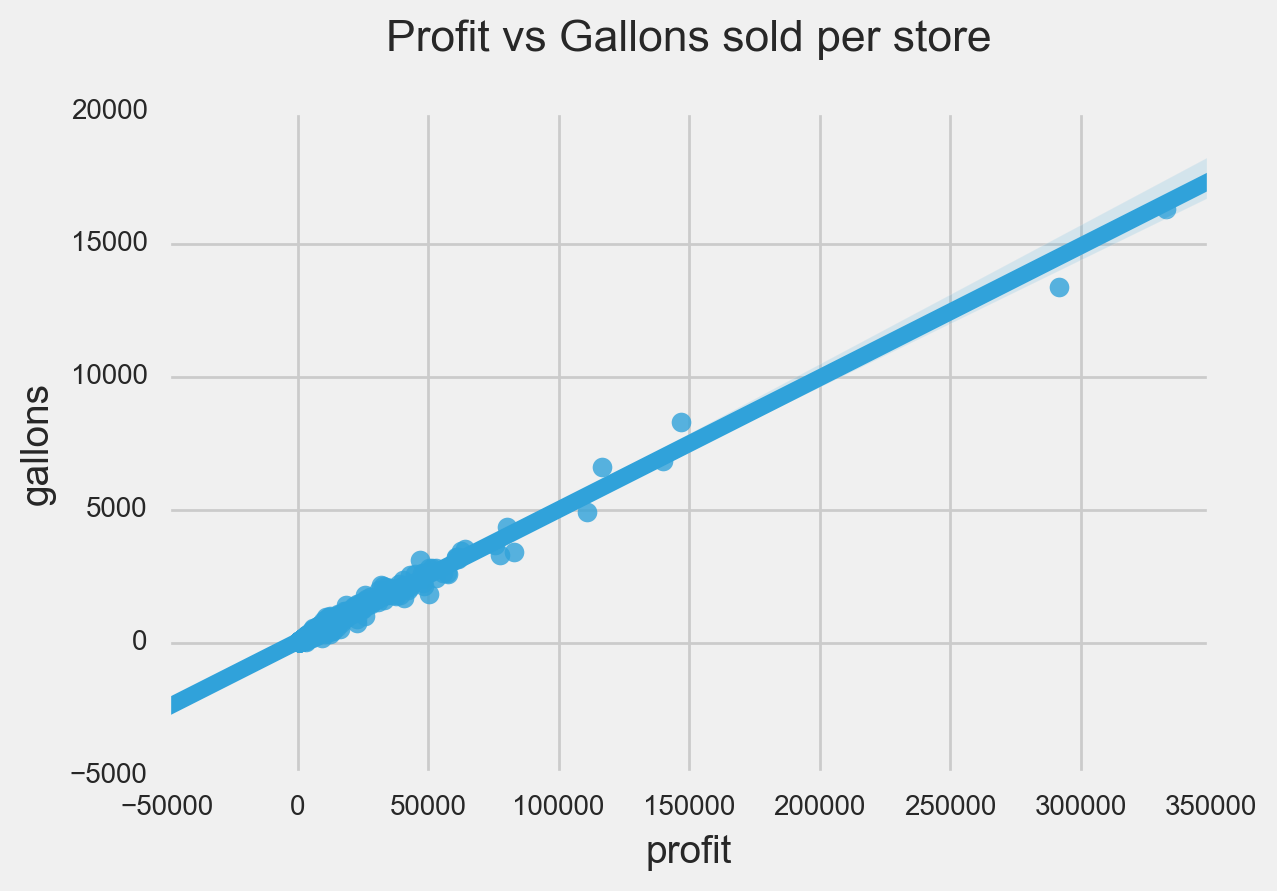

In [54]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()

profit = store_profit_gallon.profit.values
gallons = store_profit_gallon.volume_sold_gallons.values

sns.regplot(profit, gallons, ax=ax, scatter_kws={'s':50})
ax.set_xlabel('profit', fontsize=14)
ax.set_ylabel('gallons', fontsize=14)
ax.set_title('Profit vs Gallons sold per store\n', fontsize=16)
plt.show()

### 4-5 A broader category for liquor type

In [59]:
# Extract specific words from the string to make a substring variable
# Cite: Python for Data Anaylsis: Data Wrangling with Pandas, NumPy, and IPython (Page 24)
all_store['liquor_type']=np.where(all_store['category_name'].str.contains('VODKA'), "Vodka",
            np.where(all_store['category_name'].str.contains('WHISKIES'), "Whisky",
            np.where(all_store['category_name'].str.contains('SCHNAPPS'), "Schnapp",
            np.where(all_store['category_name'].str.contains('GINS'), "Gin",
            np.where(all_store['category_name'].str.contains('TRIPLE SEC'), "Triple Sec",
            np.where(all_store['category_name'].str.contains('TEQUILA'), "Tequila",
            np.where(all_store['category_name'].str.contains('RUM'), "Rum",
            np.where(all_store['category_name'].str.contains('BRANDIES'), "Brandy", "Others"))))))))

/Users/Kate/anaconda2/envs/econ/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
all_store[0:5]

,date,store_number,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day,profit,liquor_type
0,11/04/2015,3717,sumner,50674,9,Bremer,1051100,APRICOT BRANDIES,55,54436,...,6.75,12,81.00,9.00,2.38,2015,11,4,27.00,Brandy
4,08/18/2015,3654,belmond,50421,99,Wright,1031080,VODKA 80 PROOF,297,35918,...,10.80,12,129.60,21.00,5.55,2015,8,18,43.20,Vodka
5,04/20/2015,2569,cedar rapids,52402,57,Linn,1041100,AMERICAN DRY GINS,205,31473,...,19.98,6,119.88,10.50,2.77,2015,4,20,39.96,Gin
6,08/05/2015,2596,ottumwa,52501,90,Wapello,1051010,AMERICAN GRAPE BRANDIES,85,52806,...,9.99,3,29.97,2.25,0.59,2015,8,5,9.99,Brandy
7,06/25/2015,3456,clear lake,50428,17,Cerro Gordo,1012100,CANADIAN WHISKIES,65,10628,...,23.63,2,47.26,3.50,0.92,2015,6,25,15.76,Whisky


In [62]:
# Test the relationship between the new broader and profit
all_store['profit_per_gallon'] = all_store.profit/all_store.volume_sold_gallons
all_store.sort_values('profit_per_gallon', ascending=False, inplace=True)
all_store[0:5]

/Users/Kate/anaconda2/envs/econ/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Kate/anaconda2/envs/econ/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,date,store_number,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day,profit,liquor_type,profit_per_gallon
196351,02/26/2015,2663,urbandale,50322,77,Polk,1012200,SCOTCH WHISKIES,260,995381,...,1,637.50,0.75,0.20,2015,2,26,212.5,Whisky,1062.500000
255223,06/30/2015,3952,bettendorf,52722,82,Scott,1012200,SCOTCH WHISKIES,260,994764,...,1,524.99,0.75,0.20,2015,6,30,175.0,Whisky,875.000000
90202,11/09/2015,3952,bettendorf,52722,82,Scott,1042100,IMPORTED DRY GINS,35,902282,...,20,480.00,1.00,0.26,2015,11,9,160.0,Gin,615.384615
160897,09/08/2015,2665,waukee,50263,25,Dallas,1011200,STRAIGHT BOURBON WHISKIES,65,919471,...,10,235.80,0.50,0.13,2015,9,8,78.6,Whisky,604.615385
3011,06/23/2015,4070,belle plaine,52208,6,Benton,1052010,IMPORTED GRAPE BRANDIES,420,990482,...,1,449.99,1.00,0.26,2015,6,23,150.0,Brandy,576.923077


In [63]:
type_profit_gallon = all_store.groupby('liquor_type').profit_per_gallon.agg(np.mean).reset_index()

In [64]:
type_profit_gallon.sort_values('profit_per_gallon', ascending=False, inplace=True)
type_profit_gallon[0:5]

,liquor_type,profit_per_gallon
5,Tequila,37.671973
0,Brandy,27.255699
2,Others,26.265337
8,Whisky,25.354103
3,Rum,18.545329


## 5. New store locations

### 5-1 Sales in Q1(2015) and Q1(2016)

In [65]:
# Select the quarter periods
# Source: ECON628 lecture notes
set2015 = (iowa.month.isin([1,2,3])) & (iowa.year == 2015)
set2016 = (iowa.month.isin([1,2,3])) & (iowa.year == 2016)

iowa_q1_2015 = iowa[set2015]
iowa_q1_2016 = iowa[set2016]

In [71]:
# Total sales per store in 2 periods
q1_2015 = iowa_q1_2015.groupby(['store_number','county']).sale_dollars.agg(np.sum).reset_index()
q1_2015 = q1_2015.groupby('county').sale_dollars.agg(np.mean).reset_index()
print q1_2015[0:5]

q1_2016 = iowa_q1_2016.groupby(['store_number','county']).sale_dollars.agg(np.sum).reset_index()
q1_2016 = q1_2016.groupby('county').sale_dollars.agg(np.mean).reset_index()
print q1_2016[0:5]

      county  sale_dollars
0      Adair   1277.750000
1      Adams   2253.600000
2  Allamakee   2484.663333
3  Appanoose   2538.015000
4    Audubon   2755.375000
      county  sale_dollars
0      Adair   1685.288571
1      Adams   2196.570000
2  Allamakee   3180.255000
3  Appanoose   3566.038333
4    Audubon   1613.140000


In [72]:
# Combine 2 periods
q1_2015.rename(columns={'sale_dollars':'sales_per_store_2015'}, inplace=True)
q1_2016.rename(columns={'sale_dollars':'sales_per_store_2016'}, inplace=True)

q1_15_16 = q1_2015.merge(q1_2016, on='county')
q1_15_16[0:5]

,county,sales_per_store_2015,sales_per_store_2016
0,Adair,1277.750000,1685.288571
1,Adams,2253.600000,2196.570000
2,Allamakee,2484.663333,3180.255000
3,Appanoose,2538.015000,3566.038333
4,Audubon,2755.375000,1613.140000


In [78]:
# Calculate the difference in 2 periods in percentage increase
q1_15_16['pct_increase'] = q1_15_16.sales_per_store_2016 / q1_15_16.sales_per_store_2015
q1_15_16[0:5]

,county,sales_per_store_2015,sales_per_store_2016,%_increase,pct_increase
0,Adair,1277.750000,1685.288571,1.318950,1.318950
1,Adams,2253.600000,2196.570000,0.974694,0.974694
2,Allamakee,2484.663333,3180.255000,1.279954,1.279954
3,Appanoose,2538.015000,3566.038333,1.405050,1.405050
4,Audubon,2755.375000,1613.140000,0.585452,0.585452


In [79]:
choice = q1_15_16[q1_15_16.pct_increase > 1.]

In [80]:
choice['5yr_q1_estimate'] = choice.sales_per_store_2016 * (choice.pct_increase**5)
choice.sort_values('5yr_q1_estimate', ascending=False, inplace=True)
choice[0:5]

/Users/Kate/anaconda2/envs/econ/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Kate/anaconda2/envs/econ/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,county,sales_per_store_2015,sales_per_store_2016,%_increase,pct_increase,5yr_q1_estimate
23,Crawford,3510.266667,7506.20000,2.138356,2.138356,335598.677621
97,Worth,2015.416667,3935.97000,1.952931,1.952931,111811.493642
15,Cedar,1240.208750,2473.06875,1.994075,1.994075,77972.809461
14,Cass,2308.604444,3473.28250,1.504494,1.504494,26772.751804
11,Butler,670.638571,1226.18000,1.828377,1.828377,25054.326271


## 6. Conclusion
* In 2015, Dallas got the highest profit per gallon, which was 21.166285. 
* Also, we found that there exists positive relationship between profit and store size that a store with bigger size will have more profits.
* When applying liquor type as the broader, tequila had the highest profit per gallon (37.671973) in 2015.
* Finally, we separated our time into 2 periods, Q1(2015) and Q1(2016). Calclutaing the percentage difference, we concluded that Crawford is the best place to start a new store selling tequila.
    